In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import random
import os
import shutil
import math

In [2]:
#Packages for segmenting
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import numpy as np
import torch 
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..")

In [3]:
#Initialize image and setting and stuff
image_path = r"C:\Users\farra\Downloads\ooh.jpg"

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image)

img_org = cv2.imread(image_path)
img_org = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



#original image 
#plt.figure(figsize=(10,10))
#plt.imshow(image)
#plt.axis('on')
#plt.show()

sam = sam_model_registry["vit_b"](checkpoint=r"C:\Users\farra\Downloads\sam_vit_b_01ec64.pth")
sam.to(device=device)
pass

In [4]:
# generate sementation masks (takes a long time)


mask_generator = SamAutomaticMaskGenerator(sam)


masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())




35
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [5]:
# Create a directory to save the segmented images
output_dir = r'C:\Users\farra\Downloads\vegoutputsdemo'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


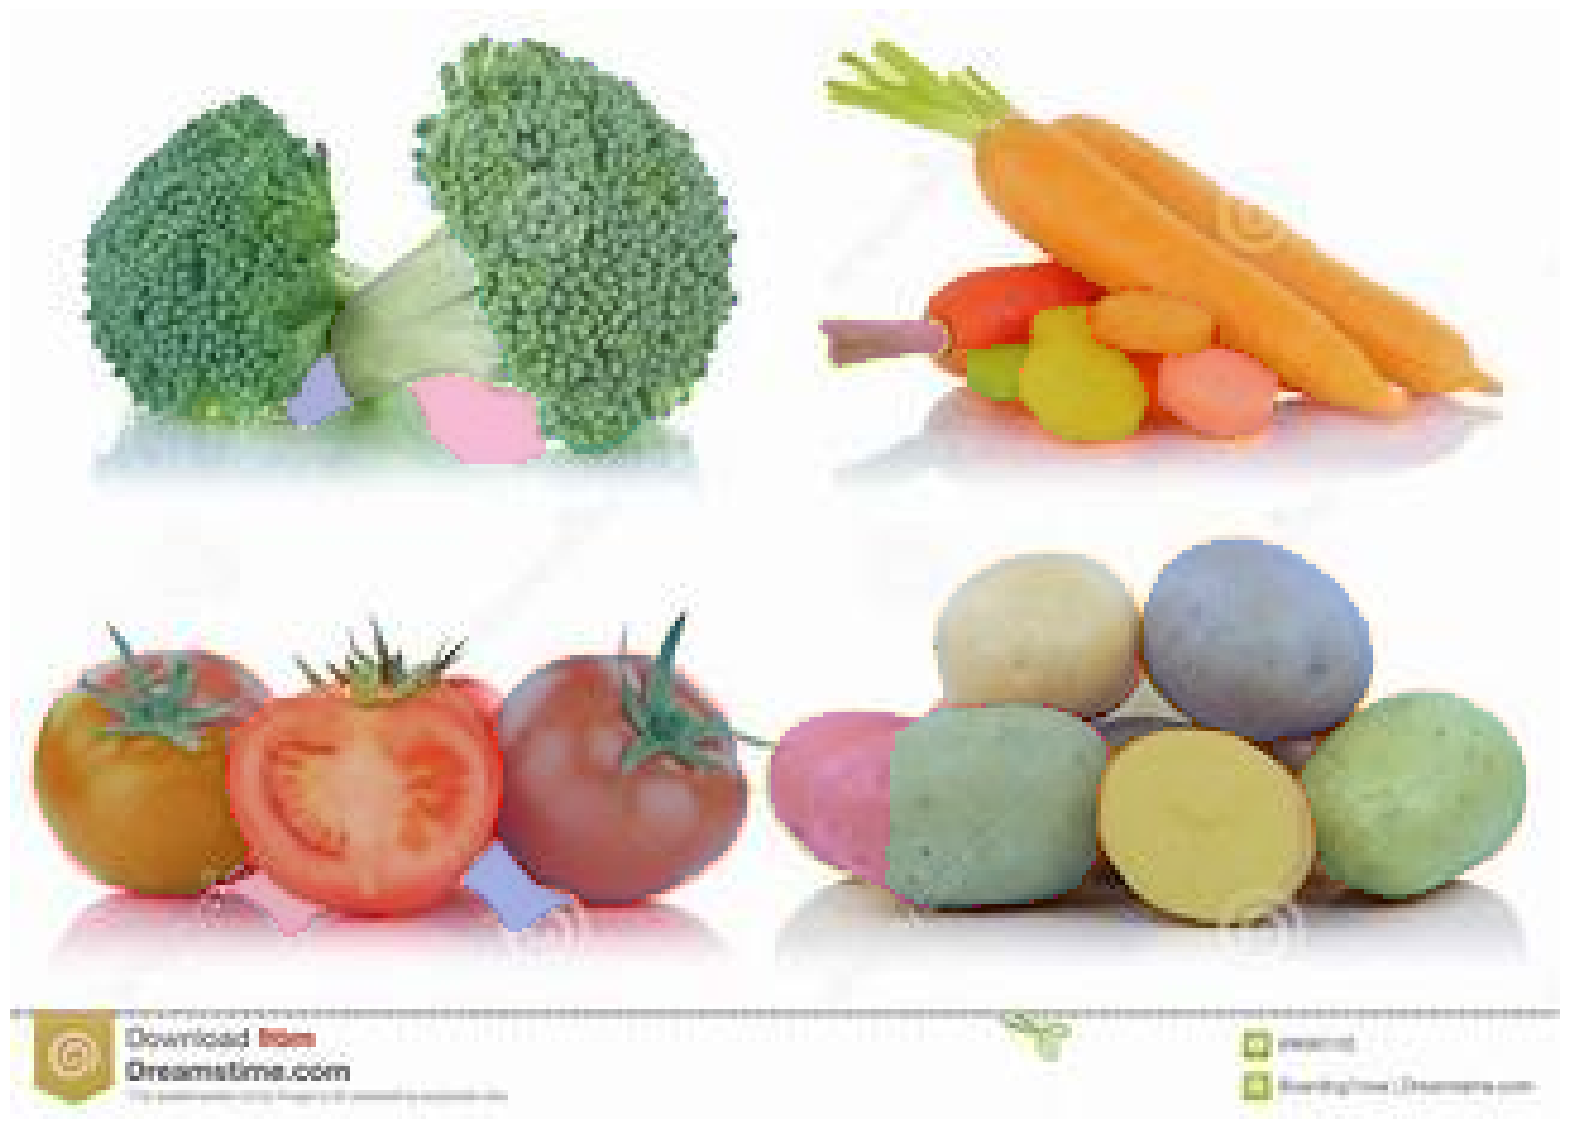

In [6]:
# Save the segmented parts of the image as individual images
from PIL import Image
segmented_list = []
for i, ann in enumerate(masks):
    mask = ann['segmentation']
    x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
    roi = image[y:y+h, x:x+w]
    
    original_roi = img_org[y:y+h, x:x+w]
    if abs(h) > image.shape[0]/10 and abs(w) > image.shape[1]/10:
        cv2.imwrite(os.path.join(output_dir, f'segmented_{i}.jpg'), original_roi)
        img = Image.open((os.path.join(output_dir, f'segmented_{i}.jpg')))
        segmented_list += [img]

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [7]:
#load saved model, this should be trained elsewhere
loaded_model = tf.keras.saving.load_model(r'C:\Users\farra\OneDrive\Desktop\Machine_Learning\InceptionV3_Vegetabletoptune_1epochs')

In [8]:
#Image preproccessing to 224x224 Note: Vales are NOT normalized

def preprocess_imageload(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.ANTIALIAS)

    # If the image is smaller than the target size, add padding
    if img.size[0] < target_size[0] or img.size[1] < target_size[1]:
        new_img = Image.new("RGB", target_size)
        new_img.paste(img, ((target_size[0] - img.size[0]) // 2, (target_size[1] - img.size[1]) // 2))
        img = new_img

    # Convert image to numpy array
    img_array = np.array(img)

    # Normalize pixel values if necessary
    #img_array = img_array / 255.0  # Normalize pixel values between 0 and 1

    return img_array

def preprocess_imagegood(image, target_size=(224, 224)):
    image_array = np.array(image, dtype=np.uint8)

    # Create a Pillow image from the NumPy array
    pillow_image = Image.fromarray(image_array)
    img = pillow_image.resize(target_size, Image.ANTIALIAS)

    # If the image is smaller than the target size, add padding
    if img.size[0] < target_size[0] or img.size[1] < target_size[1]:
        new_img = Image.new("RGB", target_size)
        new_img.paste(img, ((target_size[0] - img.size[0]) // 2, (target_size[1] - img.size[1]) // 2))
        img = new_img

    # Convert image to numpy array
    img_array = np.array(img)

    # Normalize pixel values if necessary
    #img_array = img_array / 255.0  # Normalize pixel values between 0 and 1

    return img_array



C:\Users\farra\AppData\Local\Temp\ipykernel_22164\853592811.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


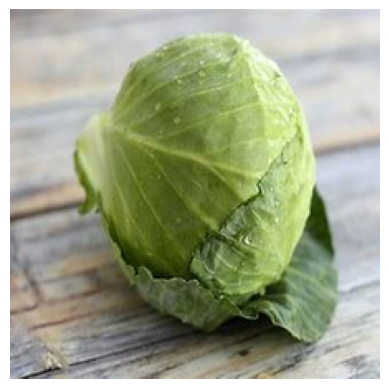

(1, 224, 224, 3)


In [10]:
# Example usage for a single non segmented image:
image_path = r"C:\Users\farra\Downloads\cabbage.jpg"
show_img = preprocess_imageload(image_path)
plt.imshow(show_img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
preprocessed_image = show_img.reshape(1, 224, 224, 3)
print(preprocessed_image.shape)

C:\Users\farra\AppData\Local\Temp\ipykernel_22164\853592811.py:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = pillow_image.resize(target_size, Image.ANTIALIAS)


18


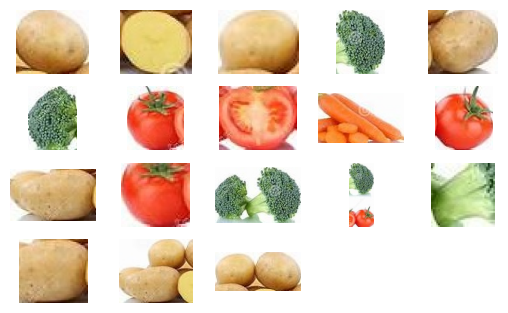

In [11]:
#Segmented usage
processed_list = []
for img in segmented_list:
    processed_list += [preprocess_imagegood(img)]
subplot_sidelen = math.ceil(math.sqrt(len(processed_list)))
print(len(processed_list))
for i in range(0, len(segmented_list)):
    ax = plt.subplot(subplot_sidelen, subplot_sidelen, i + 1)
    plt.imshow(segmented_list[i])
    plt.axis('off')

In [12]:
class_list = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

Potato
Pumpkin
Potato
Broccoli
Potato
Broccoli
Tomato
Tomato
Tomato
Tomato
Potato
Tomato
Broccoli
Broccoli
Carrot
Potato
Potato
Potato


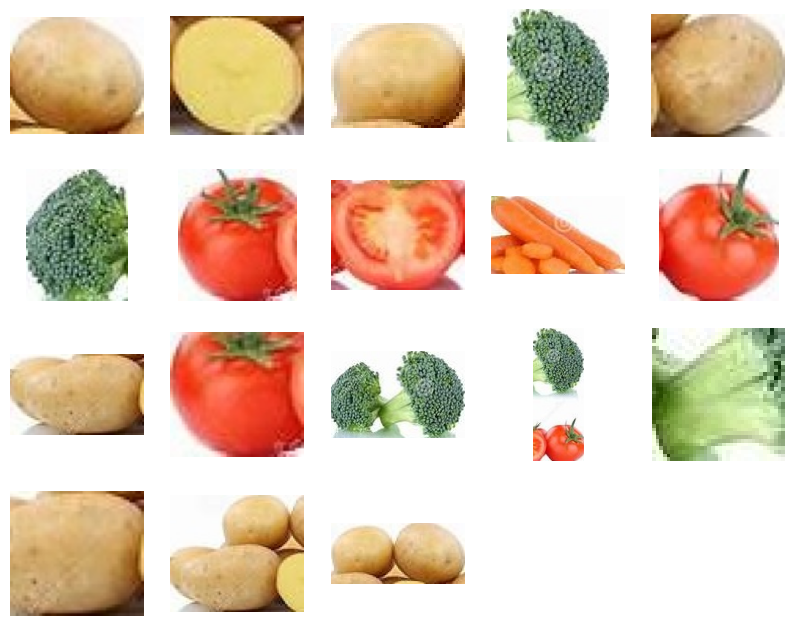

In [13]:
plt.figure(figsize=(10,10))
outputlst = []
for i in range(0, len(processed_list)):   
    img = processed_list[i]
    img = img.reshape(1, 224, 224, 3)
    predictions = loaded_model(img, training=False)
    softout = tf.nn.softmax(predictions)
    decoded_predictions = class_list[np.argmax(softout)]
    outputlst += [decoded_predictions]
    print(decoded_predictions)
 

    ax = plt.subplot(subplot_sidelen, subplot_sidelen, i + 1)
    plt.imshow(segmented_list[i])
    plt.axis('off')




#this for if using original inceptionV3: decoded_predictions = decode_predictions(predictions, top=1)
#ax = plt.figure(figsize = (10,10))
#for i in range(20):
#    plt.subplot(5, 4, i+1)
#    plt.imshow(image[i]/255.0)
#    plt.title(predictions[i])
#    plt.axis('off')

In [14]:
outputlst = set(outputlst)
print(outputlst)

{'Tomato', 'Pumpkin', 'Carrot', 'Broccoli', 'Potato'}


In [15]:
#LLM
import openai

api_key = os.environ["OPENAI_KEY"]


ingredients = outputlst


cuisine = input("What cuisine would you like to make? (any if no preference): ")
if cuisine == "any":
    cuisine = ""


input_prompt = f"I have {', '.join(ingredients)} and want to make a {cuisine} dish. Please provide a recipe for it."

response = openai.Completion.create(
    engine="text-davinci-002",
    prompt=input_prompt,
    max_tokens=200,
    api_key=api_key
)
recipe = response.choices[0].text
print("Generated Recipe:")
print(recipe)


What cuisine would you like to make? (any if no preference): Turkish
Generated Recipe:


1. Preheat oven to 375 degrees F.

2. Peel and chop the potato into small pieces.

3. Chop the broccoli into small florets.

4. Peel and chop the carrot into small pieces.

5. Cut the pumpkin into small pieces.

6. In a large pot, combine all of the chopped vegetables.

7. Add water to the pot, enough to cover the vegetables.

8.Bring the pot of water to a boil.

9. Cook the vegetables in the boiling water for 5 minutes.

10. Drain the vegetables and place them in a large baking dish.

11. Add the chopped tomatoes to the baking dish.

12. Pour the Turkish seasoning over the vegetables.

13. Toss the vegetables to coat them with the seasoning.

14. Bake the vegetables in the oven for 30 minutes.

15. Serve the baked vegetables
